In [1]:
import tensorflow as tf
from tensorflow.python.keras import models as m
from tensorflow.python.keras import layers as l

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import confusion_matrix, fbeta_score
from scikitplot.metrics import plot_roc, plot_confusion_matrix

import seaborn as sn
import pandas as pd

import ROOT as rt
from ROOT import TFile, TTree, TChain
from ROOT import TH1F, TCanvas

import copy
import os
import sys
sys.path.insert(0, os.path.abspath('/home/arsahasransu/Documents/SoftDisplacedLeptons/Classifier/'))

print("All classes initialized successfully!!!")

Welcome to JupyROOT 6.18/04
All classes initialized successfully!!!


In [2]:
import plotBeautifier as pB

In [3]:
pB.trial_func("AR")

Trial works fine. Hello,AR


In [4]:
sigChan = TChain("varTree")
sigChan.Add("signal.root")
bkgChan = TChain("varTree")
bkgChan.Add("background.root")
print("Data read from the trees. Printing out the contents.")

Data read from the trees. Printing out the contents.


In [5]:
brNameList = []
for br in sigChan.GetListOfBranches():
    brNameList.append(br.GetName())
    
print(brNameList)
print(len(brNameList))

['HtJet', 'dRLL', 'dPhiLepMETSelObj', 'YDelpObj', 'YUserObj', 'alphaT', 'Sphericity', 'Spherocity', 'MtLeadLepMET']
9


In [6]:
# Read input data from root files
sigSampleSize = sigChan.GetEntries()
bkgSampleSize = bkgChan.GetEntries()

# Convert the input data to matrices
sigFull = sigChan.AsMatrix()
bkgFull = bkgChan.AsMatrix()

print(sigFull.shape)
print(bkgFull.shape)

(44440, 9)
(4108, 9)


In [7]:
# Load the input data scaler
scaler = joblib.load("../scaler.save")

# Load the model
loaded_model = m.load_model("../simplePer.h5")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                180       
_________________________________________________________________
dropout (Dropout)            (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                342       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 38        
Total params: 560
Trainable params: 560
Non-trainable params: 0
_________________________________________________________________


2020-03-30 21:21:39.904495: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA


In [8]:
# Predict on the samples

sigFullScaled = scaler.transform(sigFull)
bkgFullScaled = scaler.transform(bkgFull)

sigFullPredict = loaded_model.predict(sigFullScaled)
bkgFullPredict = loaded_model.predict(bkgFullScaled)

print(sigFullScaled.shape)
print(sigFullPredict.shape)

(44440, 9)
(44440, 2)


HtJet


<Figure size 432x288 with 0 Axes>

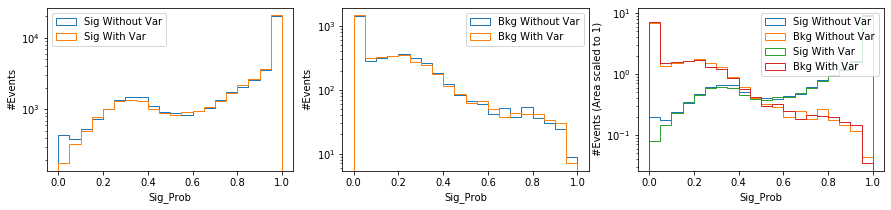

dRLL


<Figure size 432x288 with 0 Axes>

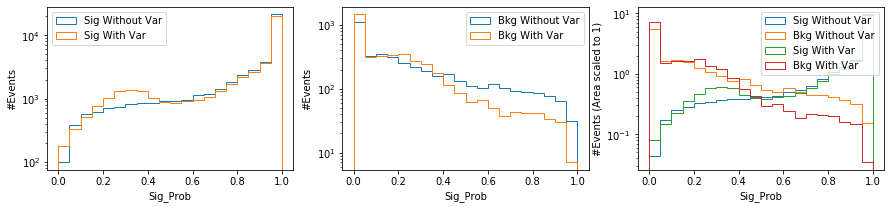

dPhiLepMETSelObj


<Figure size 432x288 with 0 Axes>

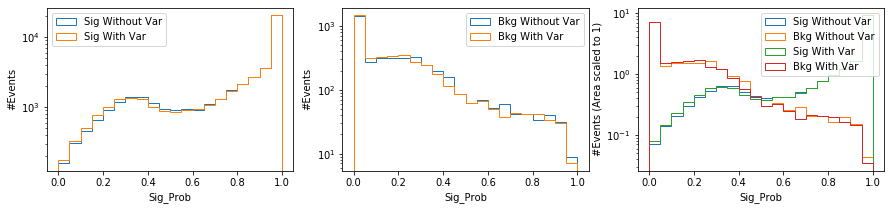

YDelpObj


<Figure size 432x288 with 0 Axes>

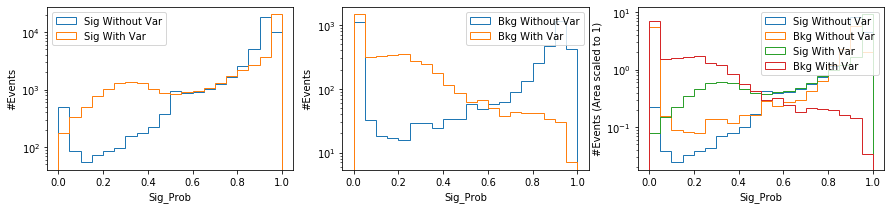

YUserObj


<Figure size 432x288 with 0 Axes>

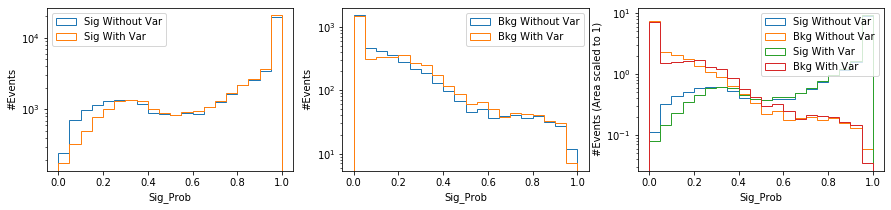

alphaT


<Figure size 432x288 with 0 Axes>

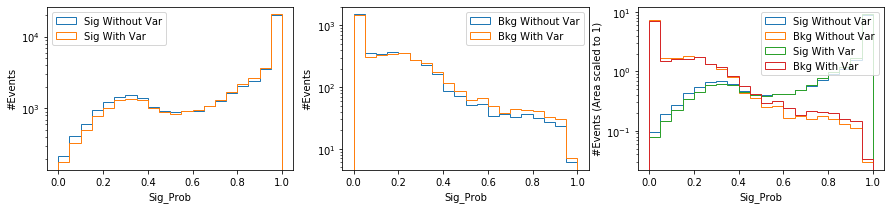

Sphericity


<Figure size 432x288 with 0 Axes>

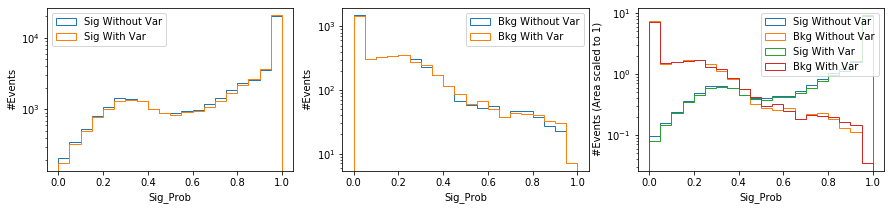

Spherocity


<Figure size 432x288 with 0 Axes>

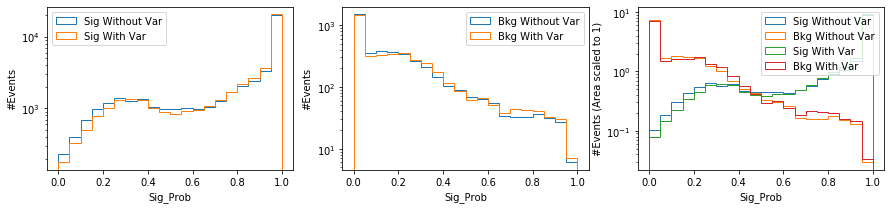

MtLeadLepMET


<Figure size 432x288 with 0 Axes>

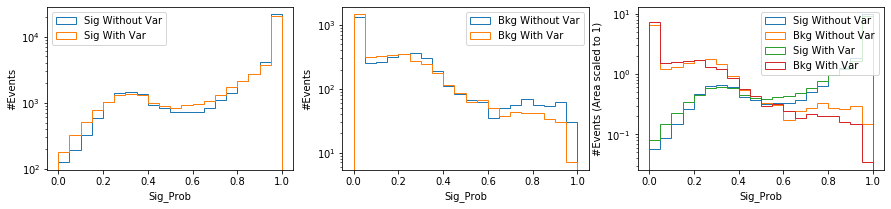

In [9]:
# Change one column of variables to zero. Choose the rest.

for i in range(len(brNameList)):
    sigFullTest = copy.copy(sigFullScaled)
    sigFullTest = np.transpose(sigFullTest)
    sigFullTest[i] = np.zeros(sigFullTest.shape[1])
    sigFullTest = np.transpose(sigFullTest)
    
    bkgFullTest = copy.copy(bkgFullScaled)
    bkgFullTest = np.transpose(bkgFullTest)
    bkgFullTest[i] = np.zeros(bkgFullTest.shape[1])
    bkgFullTest = np.transpose(bkgFullTest)

    sigTestPredict = loaded_model.predict(sigFullTest)
    bkgTestPredict = loaded_model.predict(bkgFullTest)
    
    print(brNameList[i])
    plt.clf()
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,3))

    plt.subplot(131)
    plt.yscale('log')
    plt.hist(np.array(sigTestPredict)[:,0], bins=20, range=(0,1), color=None, histtype='step', label='Sig Without Var')
    plt.hist(np.array(sigFullPredict)[:,0], bins=20, range=(0,1), color=None, histtype='step', label='Sig With Var')
    plt.xlabel("Sig_Prob")
    plt.ylabel("#Events")
    plt.legend(loc='upper left')

    plt.subplot(132)
    plt.yscale('log')    
    plt.hist(np.array(bkgTestPredict)[:,0], bins=20, range=(0,1), color=None, histtype='step', label='Bkg Without Var')
    plt.hist(np.array(bkgFullPredict)[:,0], bins=20, range=(0,1), color=None, histtype='step', label='Bkg With Var')
    plt.xlabel("Sig_Prob")
    plt.ylabel("#Events")
    plt.legend()
    
    plt.subplot(133)
    plt.yscale('log')
    plt.hist(np.array(sigTestPredict)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='Sig Without Var')
    plt.hist(np.array(bkgTestPredict)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='Bkg Without Var')
    plt.hist(np.array(sigFullPredict)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='Sig With Var')
    plt.hist(np.array(bkgFullPredict)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='Bkg With Var')
    plt.xlabel("Sig_Prob")
    plt.ylabel("#Events (Area scaled to 1)")
    plt.legend()
    plt.savefig(brNameList[i]+"MinusVar.pdf")
    plt.show()


HtJet


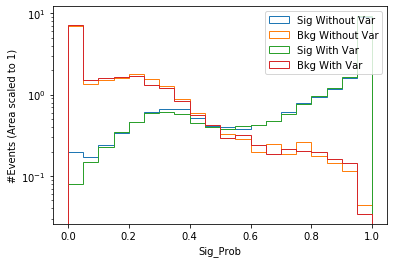

dRLL


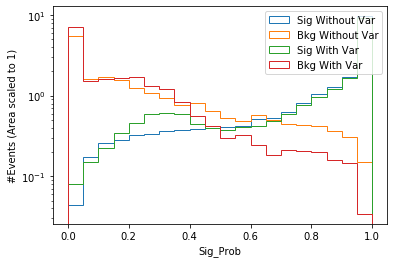

dPhiLepMETSelObj


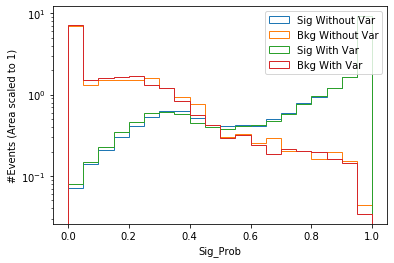

YDelpObj


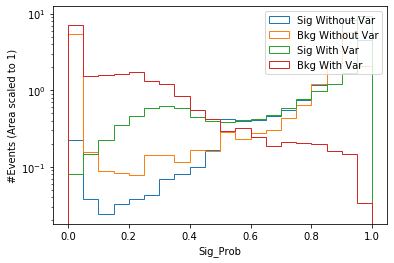

YUserObj


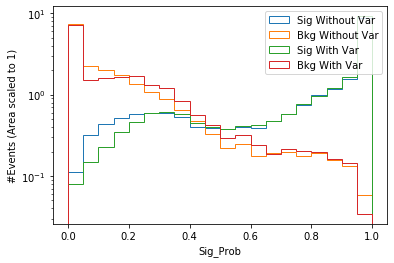

alphaT


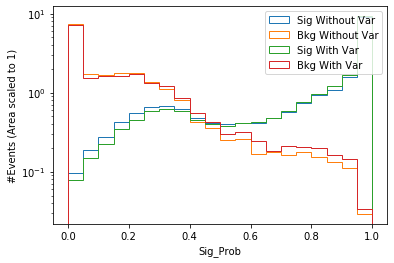

Sphericity


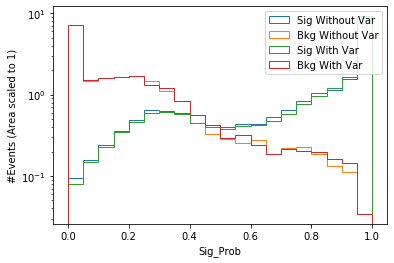

Spherocity


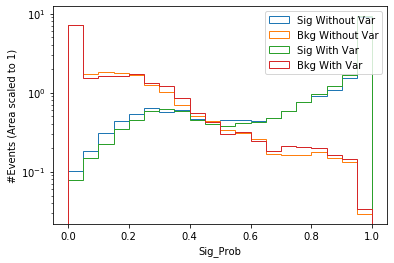

MtLeadLepMET


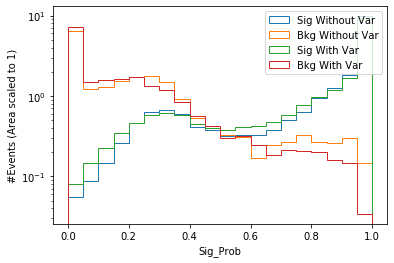

In [9]:
for i in range(len(brNameList)):
    sigFullTest = copy.copy(sigFullScaled)
    sigFullTest = np.transpose(sigFullTest)
    sigFullTest[i] = np.zeros(sigFullTest.shape[1])
    sigFullTest = np.transpose(sigFullTest)
    
    bkgFullTest = copy.copy(bkgFullScaled)
    bkgFullTest = np.transpose(bkgFullTest)
    bkgFullTest[i] = np.zeros(bkgFullTest.shape[1])
    bkgFullTest = np.transpose(bkgFullTest)

    sigTestPredict = loaded_model.predict(sigFullTest)
    bkgTestPredict = loaded_model.predict(bkgFullTest)
    
    print(brNameList[i])
    plt.clf()
    plt.yscale('log')
    plt.hist(np.array(sigTestPredict)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='Sig Without Var')
    plt.hist(np.array(bkgTestPredict)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='Bkg Without Var')
    plt.hist(np.array(sigFullPredict)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='Sig With Var')
    plt.hist(np.array(bkgFullPredict)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='Bkg With Var')
    plt.xlabel("Sig_Prob")
    plt.ylabel("#Events (Area scaled to 1)")
    plt.legend()
    plt.savefig(brNameList[i]+"MinusVar.pdf")
    plt.show()


In [10]:
# 2d correlations

sigFullSigProb = np.array(sigFullPredict)[:,0]
bkgFullSigProb = np.array(bkgFullPredict)[:,0]

sigFullVar = np.transpose(sigFull)
bkgFullVar = np.transpose(bkgFull)

minXList = [20, 0, 0, 0, 0, 0.1, 0, 0, 0]
maxXList = [100, 5, 3.14, 10, 15, 1.5, 0.7, 0.6, 100]
nBinsX = [50, 30, 25, 50, 30, 40, 30, 30, 30]

for varNum in range(len(brNameList)):
    
    print("Variable: "+brNameList[varNum])
    
    sigVarForHisto = np.array(sigFullVar[varNum])

    c1 = rt.TCanvas()
    rt.gStyle.SetOptStat(0)
    corr2dSig = rt.TH2F("","",nBinsX[varNum],minXList[varNum],maxXList[varNum],30,0,1)
    corr2dBkg = rt.TH2F("","",nBinsX[varNum],minXList[varNum],maxXList[varNum],30,0,1)
    for (x,y) in zip(sigFullVar[varNum], sigFullSigProb):
        corr2dSig.Fill(x,y,1.0/sigFullSigProb.shape[0])
    for (x,y) in zip(bkgFullVar[varNum], bkgFullSigProb):
        corr2dBkg.Fill(x,y,1.0/bkgFullSigProb.shape[0])
    print("Signal Corelation: ", corr2dSig.GetCorrelationFactor(), "Background Corelation: ",corr2dBkg.GetCorrelationFactor())
    corr2dSig.SetLineColor(rt.kBlue)
    corr2dBkg.SetLineColor(rt.kRed)
    corr2dSig.GetXaxis().SetTitle(brNameList[varNum])
    corr2dSig.GetYaxis().SetTitle("Signal Probability")
    corr2dSig.Draw("BOX")
    corr2dBkg.Draw("SAME BOX")

    legc1 = rt.TLegend(0.5, 0.91, 0.89, 1.0, "", "brNDC")
    legc1.AddEntry(corr2dSig, "Signal_BP_304_324 Cor.(%.3f)"%(corr2dSig.GetCorrelationFactor()), "l")
    legc1.SetTextSize(0.03)
    legc1.SetBorderSize(0)
    legc1.Draw()
    legc2 = rt.TLegend(0.1, 0.91, 0.49, 1.0, "", "brNDC")
    legc2.AddEntry(corr2dBkg, "Background Cor.(%.3f)"%(corr2dBkg.GetCorrelationFactor()), "l")
    legc2.SetTextSize(0.03)
    legc2.SetBorderSize(0)
    legc2.Draw()

    c1.SaveAs("./Cor2d/"+brNameList[varNum]+"Discr_cor2d.pdf")
    del c1

Variable: HtJet
Signal Corelation:  0.17171984657842446 Background Corelation:  -0.0731003607273092
Variable: dRLL
Signal Corelation:  -0.21200686113054534 Background Corelation:  0.4311490462217422
Variable: dPhiLepMETSelObj
Signal Corelation:  0.013578423411296432 Background Corelation:  0.22364822644423102
Variable: YDelpObj
Signal Corelation:  0.7951466459091889 Background Corelation:  0.2845290095525557
Variable: YUserObj
Signal Corelation:  0.14042654558133671 Background Corelation:  -0.47022914231431534
Variable: alphaT
Signal Corelation:  -0.018376339087657876 Background Corelation:  -0.0981332200359988
Variable: Sphericity
Signal Corelation:  0.12116134480795114 Background Corelation:  0.44338053370327113
Variable: Spherocity
Signal Corelation:  0.10992239041766151 Background Corelation:  0.0559746670958553
Variable: MtLeadLepMET
Signal Corelation:  0.3965178876964264 Background Corelation:  0.32928518520806105


Info in <TCanvas::Print>: pdf file ./Cor2d/HtJetDiscr_cor2d.pdf has been created
Info in <TCanvas::Print>: pdf file ./Cor2d/dRLLDiscr_cor2d.pdf has been created
Info in <TCanvas::Print>: pdf file ./Cor2d/dPhiLepMETSelObjDiscr_cor2d.pdf has been created
Info in <TCanvas::Print>: pdf file ./Cor2d/YDelpObjDiscr_cor2d.pdf has been created
Info in <TCanvas::Print>: pdf file ./Cor2d/YUserObjDiscr_cor2d.pdf has been created
Info in <TCanvas::Print>: pdf file ./Cor2d/alphaTDiscr_cor2d.pdf has been created
Info in <TCanvas::Print>: pdf file ./Cor2d/SphericityDiscr_cor2d.pdf has been created
Info in <TCanvas::Print>: pdf file ./Cor2d/SpherocityDiscr_cor2d.pdf has been created
Info in <TCanvas::Print>: pdf file ./Cor2d/MtLeadLepMETDiscr_cor2d.pdf has been created
